In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use(r'mplstyle')

import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.svm import SVC
from sklearn.utils import resample

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
from matplotlib.transforms import ScaledTranslation

In [2]:
def fit_svc(data, label):
    svc = SVC(kernel = 'linear', class_weight = 'balanced')
    svc.fit(data, label)
    w = svc.coef_[0]           # w consists of 2 elements
    a = - svc.intercept_[0] / w[1]
    b = - w[0] / w[1] 
    return a, b

def analyse_linlog_data(xx, yy, label, repeats = 50, nsample = 5000):

    lny = np.log(yy)
    data = np.array([xx, lny]).T
    
    molar_ratio = []
    B = []
    A = []
    for _ in range(repeats):
        data_resampled, label_resampled = resample(data, label, replace = True, n_samples = min(nsample, len(data)))
        a, b = fit_svc(data_resampled, label_resampled)
        B.append(b)
        A.append(a)
    B_avg = np.mean(B)
    B_std = np.std(B)
    A_avg = np.mean(A)
    A_std = np.std(A)
    
    return [A_avg, A_std, B_avg, B_std]

def take_section(df, var):
    res = np.ones(len(df)).astype(bool)
    for v in var:
        res = res & (v[1] < df[v[0]]) & (v[2] > df[v[0]])
    return df[res]

In [3]:
# nice colours! Feel free to use them :) - Daoyuan Qian 2024
colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fed9ae', '#fbad54']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = np.array([colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange])

In [4]:
df = pd.read_csv('../data/G3BP1_data.csv').sample(frac = 1)
print(df.columns)

Index(['feature', 'G3BP1 / uM', 'poly(A) / ng ul-1', 'Suramin / uM'], dtype='object')


In [5]:
RNA = r'poly(A) / ng ul-1'
G3BP1 = r'G3BP1 / uM'
suramin = r'Suramin / uM'

In [6]:
dRNA = 10
RNA_slices = [20, 60, 100]
RNA_ANAL = np.linspace(20, 180, 40)

XLIM = [0, 15]
YLIM = [0, 5]

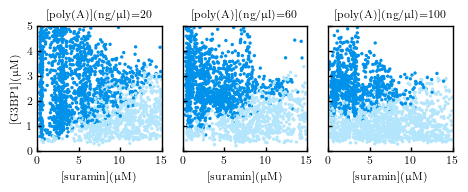

In [10]:
# 2D slices at constant RNA concentrations

fig, axes = plt.subplots(1, 3, sharex = 'row', sharey = 'row', figsize = cm2inch(12, 5))

for i in range(3):
    section = take_section(df, [[RNA, RNA_slices[i], RNA_slices[i] + dRNA],
                                [suramin, *XLIM], [G3BP1, *YLIM]])
    section = section.sample(min(2000, len(section)))

    axes[i].scatter(section[suramin],
                    section[G3BP1],
                    color = [colors[0][j] for j in section['feature'].values.astype(int)],
                    s = 2)

    axes[i].set_title(r'[{0}](ng/$\upmu$l)={1:.0f}'.format('poly(A)', RNA_slices[i]), fontsize = 8)
    axes[i].set_xlabel(r'[suramin]($\upmu$M)')

axes[0].set_ylabel(r'[G3BP1]($\upmu$M)')
axes[0].set_xlim(*XLIM)
axes[0].set_ylim(*YLIM)

plt.tight_layout()

In [11]:
res = []
for i in range(3):
    print('{0}'.format(i), end = '\r')
    section = take_section(df, [[RNA, RNA_slices[i], RNA_slices[i] + dRNA],
                                [suramin, *XLIM], [G3BP1, *YLIM]])
    xx = section[suramin]
    yy = section[G3BP1]
    res.append(analyse_linlog_data(xx, yy, section['feature'], repeats = 10, nsample = 5000))
res = np.array(res)

2

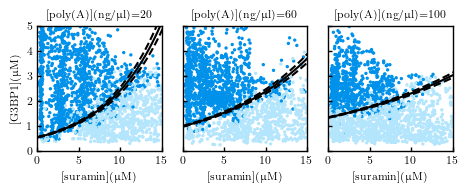

In [21]:
# 2D slices at constant RNA concentrations

fig, axes = plt.subplots(1, 3, sharex = 'row', sharey = 'row', figsize = cm2inch(12, 5))
s_grid = np.linspace(0, 20)

for i in range(3):
    section = take_section(df, [[RNA, RNA_slices[i], RNA_slices[i] + dRNA],
                                [suramin, *XLIM], [G3BP1, *YLIM]])
    
    section = section.sample(min(2000, len(section)))
    axes[i].scatter(section[suramin],
                    section[G3BP1],
                    color = [colors[0][j] for j in section['feature'].values.astype(int)],
                    s = 2)
    [A_avg, A_std, B_avg, B_std] = res[i]
    y_fit_avg = np.exp(A_avg + B_avg * s_grid)
    y_fit_iter = []
    for _1 in [-1, +1]:
        for _2 in [-1, +1]:
            y_fit_iter.append(np.exp(A_avg + _1 * A_std + s_grid * (B_avg + _2 * B_std)))
    y_fit_max = np.max(y_fit_iter, axis = 0)
    y_fit_min = np.min(y_fit_iter, axis = 0)

    axes[i].plot(s_grid, np.exp(A_avg + B_avg * s_grid), color = 'black')
    axes[i].plot(s_grid, y_fit_max, color = 'black', linestyle = 'dashed')
    axes[i].plot(s_grid, y_fit_min, color = 'black', linestyle = 'dashed')

    axes[i].set_title(r'[{0}](ng/$\upmu$l)={1:.0f}'.format('poly(A)', RNA_slices[i]), fontsize = 8)
    axes[i].set_xlabel(r'[suramin]($\upmu$M)')

axes[0].set_ylabel(r'[G3BP1]($\upmu$M)')
axes[0].set_xlim(*XLIM)
axes[0].set_ylim(*YLIM)
    
plt.tight_layout()

# plt.savefig('1.pdf')

In [13]:
RES_FINE = []

for i in range(len(RNA_ANAL)):
    print('{0}'.format(i), end = '\r')
    section = take_section(df, [[RNA, RNA_ANAL[i], RNA_ANAL[i] + dRNA],
                                [suramin, *XLIM], [G3BP1, *YLIM]])
    xx = section[suramin]
    yy = section[G3BP1]
    RES_FINE.append(analyse_linlog_data(xx, yy, section['feature'], repeats = 50, nsample = 1000))
    
RES_FINE = np.array(RES_FINE)

39

In [14]:
RES_FINE.shape

(40, 4)

In [16]:
# ng/uL to M conversion 
mow = 2100 * 1e3 # mw of RNA in kDa (700 - 3500 kDa)
vol = 1e-6 # in L
num = 1e-9 / (mow)
ngul_to_nM = num / vol * 1e9 # in nM unit
print(ngul_to_nM)

0.4761904761904762


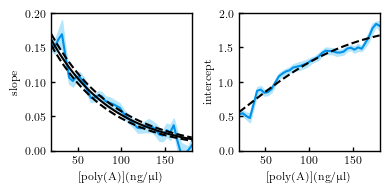

In [17]:
fig, axes = plt.subplots(1, 2, figsize = cm2inch(10, 5))

axes[0].plot(RNA_ANAL, RES_FINE.T[2], color = colors[0][1])
axes[0].fill_between(RNA_ANAL, RES_FINE.T[2] - RES_FINE.T[3], RES_FINE.T[2] + RES_FINE.T[3], color = colors[0][0])

xx = np.linspace(20, 180)
expfun = lambda x, s, k: k * np.exp(-x/s)
popt, pcov = curve_fit(expfun, RNA_ANAL, RES_FINE.T[2], p0 = (100, 0.3), sigma = RES_FINE.T[3])
perr = np.sqrt(np.diag(pcov))

y_fit_avg = expfun(xx, *popt)
y_fit_iter = []
for _1 in [-1, +1]:
    for _2 in [-1, +1]:
        y_fit_iter.append(expfun(xx, *(popt + perr * np.array([_1, _2]))))
y_fit_max = np.max(y_fit_iter, axis = 0)
y_fit_min = np.min(y_fit_iter, axis = 0)

axes[0].plot(xx, y_fit_avg, color = 'black')
axes[0].plot(xx, y_fit_max, color = 'black', linestyle = 'dashed')
axes[0].plot(xx, y_fit_min, color = 'black', linestyle = 'dashed')

# axes[0].plot(xx, expfun(xx, *popt), color = 'black', linestyle = 'dashed')


exp2fun = lambda x, c, v: c * np.exp(-v * np.exp(-x/(popt[0])))
popt2, pcov2 = curve_fit(exp2fun, RNA_ANAL, np.exp(RES_FINE.T[0]), p0 = (100, 0.3), sigma = np.exp(RES_FINE.T[0] - RES_FINE.T[1]) - np.exp(RES_FINE.T[0]))

axes[1].plot(RNA_ANAL, np.exp(RES_FINE.T[0]), color = colors[0][1])
axes[1].fill_between(RNA_ANAL, np.exp(RES_FINE.T[0] - RES_FINE.T[1]), np.exp(RES_FINE.T[0] + RES_FINE.T[1]), color = colors[0][0])
axes[1].plot(xx, exp2fun(xx, *popt2), color = 'black', linestyle = 'dashed')
perr2 = np.sqrt(np.diag(pcov2))

for i in range(2):
    axes[i].set_xlabel(r'[poly(A)](ng/$\upmu$l)')
    axes[i].set_xlim(20, 180)
axes[0].set_ylabel('slope')
axes[1].set_ylabel('intercept')

axes[0].set_ylim(0, 0.2)
axes[1].set_ylim(0, 2)

plt.tight_layout()